In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

2.11.0
1.23.5


# train

In [2]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")
    print(len(images), "images to be resized.")
    
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    print(len(images), "images resized.")

In [3]:
# image_dir_path = "data/rock_scissor_paper/scissor"
# resize_images(image_dir_path)
# print("가위 이미지 resize 완료!")

# image_dir_path = "data/rock_scissor_paper/rock"
# resize_images(image_dir_path)
# print("바위 이미지 resize 완료!")

# image_dir_path = "data/rock_scissor_paper/paper"
# resize_images(image_dir_path)
# print("보 이미지 resize 완료!")

In [4]:
def load_data(img_path, number_of_data=923):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "data/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 923 입니다.
x_train shape: (923, 28, 28, 3)
y_train shape: (923,)


In [5]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x_train,
                                                 y_train,
                                                 test_size=0.3,
                                                 random_state=42)

라벨:  0
(28, 28, 3)


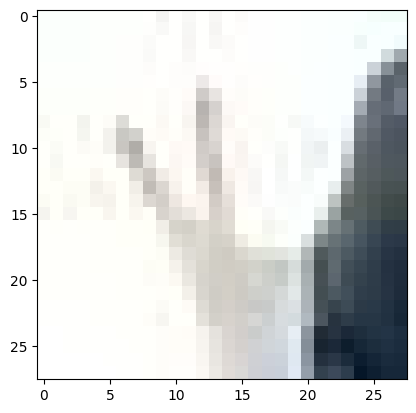

In [6]:
plt.imshow(x_train[23])
print('라벨: ', y_train[23])
print(x_train[23].shape)

# train

In [7]:
n_channel_1=28
n_channel_2=56
n_channel_3=72

n_dense= 16
n_train_epoch=100
batch_size = 1
lr = 0.002

model=keras.models.Sequential()

model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3),
                              kernel_initializer=tf.keras.initializers.HeNormal()),
)
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu', input_shape=(28,28,3),
                              kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu',
                              kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.L1(0.01),
                             activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 28)        0         
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 28)       112       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 56)         0

Conv2D에서 relu가 활성화함수이기 때문에 HE normal로 가중치 초기화, 실험에서 안정성을 위해 BatchNormalization을 각각 추가해줬고, Dropout을 0.3으로 주어 과적합을 피하고자 했다.  

In [8]:
def load_data(img_path, number_of_data=923):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "data/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 923 입니다.
x_train shape: (923, 28, 28, 3)
y_train shape: (923,)


In [9]:
def scheduler(epoch, lr):
      if epoch < 10:
          return lr
      else:
          return lr * tf.math.exp(-0.1)

sc = tf.keras.callbacks.LearningRateScheduler(scheduler)
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

model.compile(tf.keras.optimizers.Adam(learning_rate=lr),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train, y_train, epochs=n_train_epoch,
                    validation_data = (x_val,y_val), callbacks=[sc,es])

Epoch 1/100
29/29 [==============================] - 4s 50ms/step - loss: 3.6215 - accuracy: 0.2069 - val_loss: 4.3257 - val_accuracy: 0.3141 - lr: 0.0020
Epoch 2/100
29/29 [==============================] - 1s 36ms/step - loss: 2.8254 - accuracy: 0.4117 - val_loss: 3.1117 - val_accuracy: 0.3249 - lr: 0.0020
Epoch 3/100
29/29 [==============================] - 1s 33ms/step - loss: 2.3772 - accuracy: 0.5125 - val_loss: 2.2499 - val_accuracy: 0.4729 - lr: 0.0020
Epoch 4/100
29/29 [==============================] - 1s 33ms/step - loss: 2.0241 - accuracy: 0.5829 - val_loss: 1.6741 - val_accuracy: 0.6968 - lr: 0.0020
Epoch 5/100
29/29 [==============================] - 1s 33ms/step - loss: 1.7503 - accuracy: 0.6262 - val_loss: 1.3436 - val_accuracy: 0.7942 - lr: 0.0020
Epoch 6/100
29/29 [==============================] - 1s 42ms/step - loss: 1.5106 - accuracy: 0.7031 - val_loss: 1.1464 - val_accuracy: 0.8123 - lr: 0.0020
Epoch 7/100
29/29 [==============================] - 1s 34ms/step - lo

## 시각화

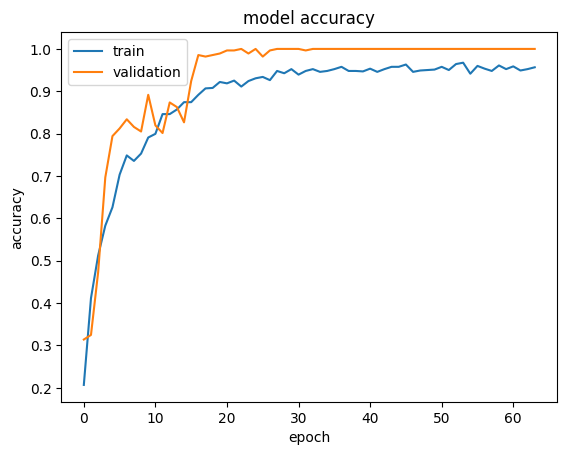

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

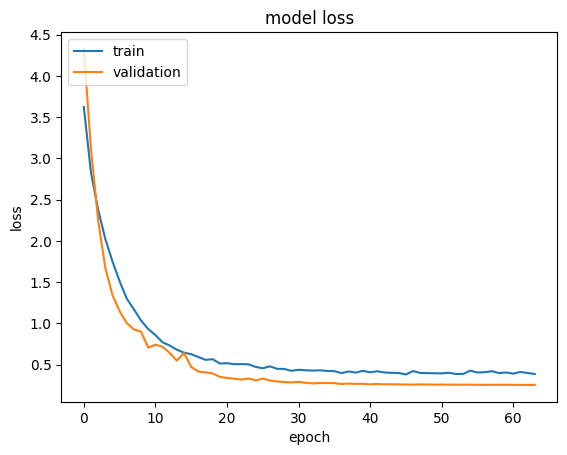

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# test 평가

In [12]:
# image_dir_path = "data/rock_scissor_paper/test/rock"
# resize_images(image_dir_path)
# print("바위 이미지 resize 완료!")

# image_dir_path = "data/rock_scissor_paper/test/scissor"
# resize_images(image_dir_path)
# print("가위 이미지 resize 완료!")

# image_dir_path = "data/rock_scissor_paper/test/paper"
# resize_images(image_dir_path)
# print("보 이미지 resize 완료!")

image_dir_path = "./data/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path, 300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [15]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

10/10 - 0s - loss: 0.7913 - accuracy: 0.7267 - 130ms/epoch - 13ms/step


train data: 제 사진과 은정님, 혜원님 사진을 넣었습니다.  
test data: 승호님의 사진을 test로 넣어줬습니다.  
실험 결과 test accuracy: 0.7267 